## <center>Kaggle competition "How good is your Medium article?"
    


[Competition](https://www.kaggle.com/c/how-good-is-your-medium-article)

In [2]:
import os
import json
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error as MAE
import gensim
from gensim.matutils  import Sparse2Corpus
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import gc
import nltk
import warnings

C:\Users\Aqice\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Aqice\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [20]:
PATH_TO_DATA = 'data'

In [2]:
from html.parser import HTMLParser


class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Supplementary function to read a JSON line without crashing on escape characters.

In [3]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

In [5]:
def extract_features_and_write(path_to_data,
                               inp_filename, is_train=True):
    
    features = ['content', 'published', 'title', 'author']
    prefix = 'train' if is_train else 'test'
    feature_files = [open(os.path.join(path_to_data,
                                       '{}_{}.txt'.format(prefix, feat)),
                          'w', encoding='utf-8')
                     for feat in features]
    df = pd.DataFrame(columns=features)
    with open(os.path.join(path_to_data, inp_filename), 
              encoding='utf-8') as inp_json_file:
        for line in tqdm_notebook(inp_json_file):
            json_data = read_json_line(line)
            content = strip_tags(json_data['content'].replace('\n', ' ').replace('\r', ' '))
            published = json_data['published']['$date']
            title = json_data['meta_tags']['title'].split('\u2013')[0].strip()
            author = json_data['meta_tags']['author'].strip()
            df = df.append({'content': content, 'published': published, 'title': title, 'author': author}, ignore_index=True)
    df.to_csv('{}_data.csv'.format(prefix), index=False)

In [6]:
extract_features_and_write(PATH_TO_DATA, 'train.json', is_train=True)

In [7]:
extract_features_and_write(PATH_TO_DATA, 'test.json', is_train=False)

# Main part

In [51]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
train_size = len(train)

In [52]:
data = pd.concat([train, test], axis=0)

In [53]:
%%time
data_features = pd.DataFrame(pd.to_datetime(data.published))
data_features['author'] = data.author
data_features['year'] = data_features['published'].apply(lambda i: i.year)
data_features['hour'] = data_features['published'].apply(lambda i: i.hour)
data_features['day'] = data_features['published'].apply(lambda i: i.day)
data_features['weekday'] = data_features['published'].apply(lambda i: i.weekday())
data_features['month'] = data_features['published'].apply(lambda i: i.month)
data_features['morning'] = data_features['hour'].apply(lambda i: 1 if 6<i<13 else 0)
data_features['day'] = data_features['hour'].apply(lambda i: 1 if 12<i<18 else 0)
data_features['evening'] = data_features['hour'].apply(lambda i: 1 if 17<i<24 else 0)
data_features['night'] = data_features['hour'].apply(lambda i: 1 if -1<i<7 else 0)
data_features = pd.concat([data_features, pd.get_dummies(data_features, columns=[
   'morning', 'day', 'evening', 'night', 'weekday', 'year'
])], axis=1)
data_features.drop(['year', 'hour', 'day', 'month', 'morning', 'day', 'evening', 'night', 'author', 'published', 'weekday'],
                   axis=1, inplace=True)

Wall time: 3.84 s


In [54]:
data_features.head()

,morning_0,morning_1,day_0,day_1,evening_0,evening_1,night_0,night_1,weekday_0,weekday_1,...,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,1,0,1,0,0,1,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,0,1,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [55]:
X_train_feats = data_features.iloc[:train_size, :]
X_test_feats = data_features.iloc[train_size:, :]

### Lemmatization

In [8]:
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

train_cont_lem = [porter_stemmer.stem(i) for i in train.content.values]
test_cont_lem = [porter_stemmer.stem(i) for i in test.content.values]

### Tf-Idf in action

In [56]:
vectorizer = TfidfVectorizer(max_features=50000, min_df = 0.1, max_df = 0.8)

In [57]:
%%time
X_train_title = vectorizer.fit_transform(train.title)
X_test_title = vectorizer.transform(test.title)

X_train_content = vectorizer.fit_transform(train_cont_lem)
X_test_content = vectorizer.transform(test_cont_lem)

print(X_train_content.shape, X_test_content.shape)
print(X_train_title.shape, X_test_title.shape)



(62313, 913) (34645, 913)
(62313, 4) (34645, 4)
Wall time: 6min 11s


In [58]:
del train
del test
del data
del data_features
gc.collect()

27

### LDA

In [12]:
full_sparse_data =  sparse.vstack([X_train_content, X_test_content])

In [13]:
warnings.filterwarnings('ignore')
## prepare full data content
corpus_data_gensim = gensim.matutils.Sparse2Corpus(full_sparse_data, documents_columns=False)
vocabulary_gensim = {}
for key, val in vectorizer.vocabulary_.items():
    vocabulary_gensim[val] = key
    
dict = Dictionary()
dict.merge_with(vocabulary_gensim)

lda = LdaModel(corpus_data_gensim, num_topics = 30 )

In [14]:
def document_to_lda_features(lda_model, document):
    topic_importances = lda.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

lda_features = list(map(lambda doc:document_to_lda_features(lda, doc),corpus_data_gensim))

In [15]:
data_pd_lda_features = pd.DataFrame(lda_features)
data_pd_lda_features.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.004189,0.004189,0.004189,0.004189,0.004189,0.878518,0.004189,0.004189,0.004189,0.004189,...,0.004189,0.004189,0.004189,0.004189,0.004189,0.004189,0.004189,0.004189,0.004189,0.004189
1,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785,...,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785
2,0.008078,0.274950,0.008078,0.008078,0.008078,0.008078,0.008078,0.008078,0.008078,0.008078,...,0.008078,0.008078,0.008078,0.325043,0.008078,0.008078,0.008078,0.181897,0.008078,0.008078
3,0.002763,0.002763,0.002763,0.701904,0.002763,0.002763,0.002763,0.002763,0.002763,0.002763,...,0.002763,0.002763,0.002763,0.002763,0.002763,0.002763,0.220727,0.002763,0.002763,0.002763
4,0.003179,0.003179,0.003179,0.003179,0.003179,0.003179,0.003179,0.003179,0.003179,0.003179,...,0.003179,0.003179,0.003179,0.003179,0.003179,0.003179,0.003179,0.003179,0.003179,0.003179


In [16]:
data_pd_lda_features_train = data_pd_lda_features.iloc[:train_size]
data_pd_lda_features_test = data_pd_lda_features.iloc[train_size:]

In [59]:
%%time
X_train_sparse = hstack([X_train_content, X_train_feats.values, data_pd_lda_features_train,
                         data_pd_lda_features_train]).tocsr()
X_test_sparse = hstack([X_test_content, X_test_feats.values, data_pd_lda_features_test,
                         data_pd_lda_features_test]).tocsr()

print(X_train_sparse.shape)
print(X_test_sparse.shape)

(62313, 976)
(34645, 976)
Wall time: 3.38 s


**Read train target and split data for validation.**

In [60]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')
y_train = train_target['log_recommends'].values

In [61]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part_sparse = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid_sparse =  X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

**Train a simple Ridge model and check MAE on the validation set.**

In [62]:
%%time
linear_regressor_ridge = Ridge()
linear_regressor_ridge.fit(X_train_part_sparse, y_train_part)

Wall time: 8.62 s


In [63]:
ridge_preds = linear_regressor_ridge.predict(X_valid_sparse)
print('Linear regression MAE: {}'.format(MAE(ridge_preds, y_valid)))

Linear regression MAE: 1.2979073563360202


### training & blending lgb

In [64]:
import lightgbm as lgb

In [65]:
%%time
lgb_train = lgb.Dataset(X_train_part_sparse.astype(np.float32), 
                        label=np.log1p(y_train_part))
lgb_x_valid = lgb.Dataset(X_valid_sparse.astype(np.float32), 
                      label=np.log1p(y_valid))
param = {'num_leaves': 31, 'num_iterators': 100, 'objective': 'mean_absolute_error',
        'metric': 'mae'}
num_round = 120
bst_lgb = lgb.train(param, lgb_train, num_round, valid_sets=[lgb_x_valid], early_stopping_rounds=20)

[1]	valid_0's l1: 0.38204
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l1: 0.376929
[3]	valid_0's l1: 0.373066
[4]	valid_0's l1: 0.369308
[5]	valid_0's l1: 0.366432
[6]	valid_0's l1: 0.363983
[7]	valid_0's l1: 0.36187
[8]	valid_0's l1: 0.359969
[9]	valid_0's l1: 0.358353
[10]	valid_0's l1: 0.356928
[11]	valid_0's l1: 0.35522
[12]	valid_0's l1: 0.354011
[13]	valid_0's l1: 0.352725
[14]	valid_0's l1: 0.351806
[15]	valid_0's l1: 0.350663
[16]	valid_0's l1: 0.34984
[17]	valid_0's l1: 0.348962
[18]	valid_0's l1: 0.348426
[19]	valid_0's l1: 0.347543
[20]	valid_0's l1: 0.346997
[21]	valid_0's l1: 0.346466
[22]	valid_0's l1: 0.345993
[23]	valid_0's l1: 0.345619
[24]	valid_0's l1: 0.345064
[25]	valid_0's l1: 0.344689
[26]	valid_0's l1: 0.34421
[27]	valid_0's l1: 0.343703
[28]	valid_0's l1: 0.343167
[29]	valid_0's l1: 0.342763
[30]	valid_0's l1: 0.342302
[31]	valid_0's l1: 0.341871
[32]	valid_0's l1: 0.34147
[33]	valid_0's l1: 0.340971
[34]	valid_0's l1: 0.340506
[

In [66]:
lgb_pred = np.expm1(bst_lgb.predict(X_valid_sparse.astype(np.float32), 
                                    num_iteration=bst_lgb.best_iteration))

In [67]:
print('LGB answers MAE: {}'.format(MAE(lgb_pred, y_valid)))

LGB answers MAE: 1.230881815816043


In [68]:
import matplotlib.pyplot as plt

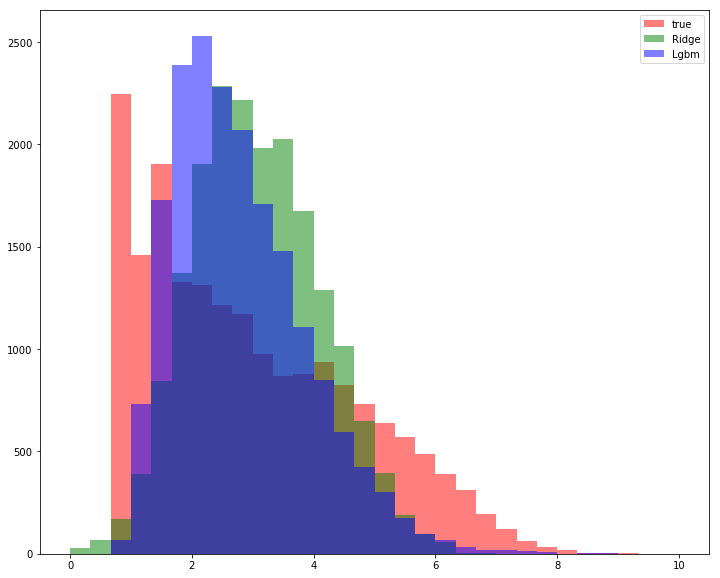

In [69]:
figure = plt.figure(figsize=(12,10))
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_preds, bins=30, alpha=.5, color='green', label='Ridge', range=(0,10));
plt.hist(lgb_pred, bins=30, alpha=.5, color='blue', label='Lgbm', range=(0,10));
plt.legend();

0.25 0.75


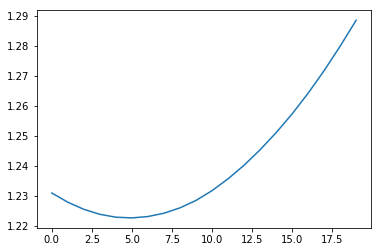

In [71]:
def blending(ans1, ans2, valid, step=0.05):
    errors = []
    for i in np.arange(0, 1, step):
        errors.append(MAE(i*ans1 + (1-i)*ans2, valid))
    plt.plot(errors)
    return (np.argmin(errors)*step, (1 - np.argmin(errors)*step))
    
    
coef1, coef2 = blending(np.array(ridge_preds), lgb_pred, y_valid)
print(coef1, coef2)

In [72]:
blending_ans = ridge_preds * coef1 + lgb_pred * coef2
print('blending answers MAE: {}'.format(MAE(blending_ans, y_valid)))

blending answers MAE: 1.222560758660127


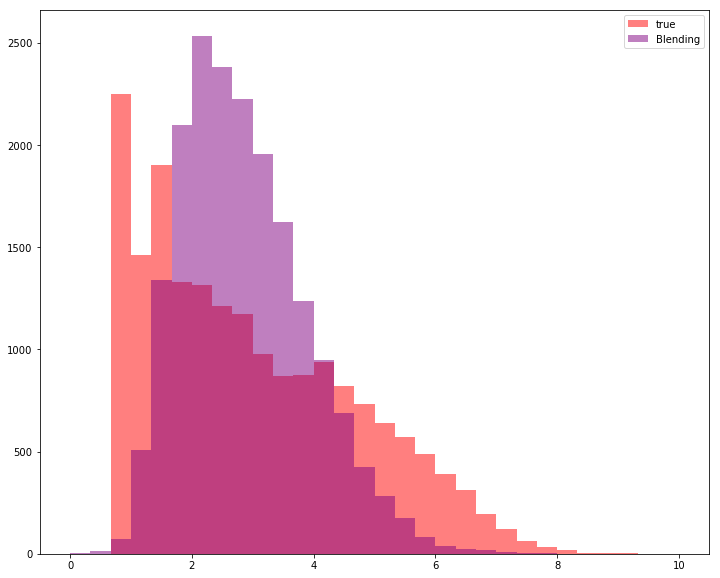

In [73]:
figure = plt.figure(figsize=(12,10))
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(blending_ans, bins=30, alpha=.5, color='purple', label='Blending', range=(0,10));
plt.legend();

### training & trying to blend  XGB

In [39]:
import xgboost
xgboost.__version__

'0.80'

In [40]:
%%time
xgb = xgboost.XGBRegressor(n_estimators=100, n_jobs=-1, objective='reg:linear')
xgb.fit(X_train_part_sparse, np.log1p(y_train_part), )
#         eval_set=(X_valid_sparse.getnnz(), np.log1p(y_valid)), eval_metric='mae')
xgb_answers = np.expm1(xgb.predict(X_valid_sparse.astype(np.float32)))

Wall time: 56.5 s


In [41]:
print('XGB MAE: {}'.format(MAE(xgb_answers, y_valid)))

XGB MAE: 1.2761902311626185


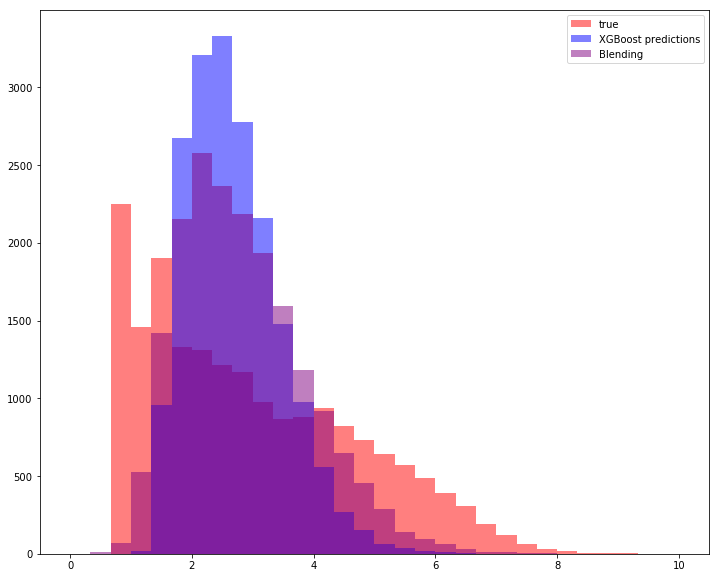

In [42]:
figure = plt.figure(figsize=(12,10))
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(xgb_answers, bins=30, alpha=.5, color='blue', label='XGBoost predictions', range=(0,10));
plt.hist(blending_ans, bins=30, alpha=.5, color='purple', label='Blending', range=(0,10));
plt.legend();

0.99 0.010000000000000009


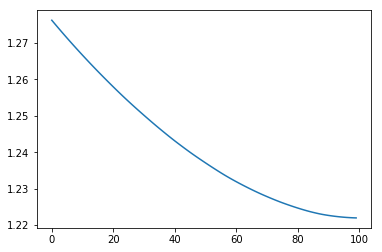

In [43]:
coef1_xgb, coef2_xgb = blending(blending_ans, xgb_answers, y_valid, step=0.01)
print(coef1_xgb, coef2_xgb)

Blending with xgboost doesn't give any advantages

In [74]:
def dirty_kaggle_trick(preds):
    return (preds)/np.mean(preds) * 4.33

# Final submission

In [75]:
def prepare_final_data(dirty=False):
    linear_regressor_ridge.fit(X_train_sparse, y_train)
    ridge_preds = linear_regressor_ridge.predict(X_test_sparse)
    
    print('ridge finished')
    
    lgb_train = lgb.Dataset(X_train_sparse.astype(np.float32), 
                        label=np.log1p(y_train))
    param = {'num_leaves': 31, 'num_iterators': 100, 'objective': 'mean_absolute_error',
            'metric': 'mae'}
    num_round = 100
    bst_lgb = lgb.train(param, lgb_train, num_round)
    lgb_pred = np.expm1(bst_lgb.predict(X_test_sparse.astype(np.float32)))
    
    print('lgb finished')
    
    blending_ans = ridge_preds * coef1 + lgb_pred * coef2
    
    final = dirty_kaggle_trick(blending_ans)
    
    return final
    

    

In [76]:
%%time
ans = prepare_final_data()

ridge finished
lgb finished
Wall time: 1min 2s


In [49]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA, 
                                                      'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    print(submission.shape)
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [77]:
write_submission_file(ans, os.path.join(PATH_TO_DATA,
                                                    'blending_with_hack.csv'))

(34645, 1)
